## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ../..

/home/jovyan/Robbi/dea-intertidal


Install additional packages directly from the requirements file

In [ ]:
# pip install -r requirements.in --quiet

### Load packages

In [6]:
%load_ext autoreload
%autoreload 2

from IPython.display import Image

# import datacube
import glob
import xarray as xr
import pandas as pd
import numpy as np

import datacube
# from datacube.utils.geometry import assign_crs
import odc.geo.xr
from dea_tools.plotting import xr_animation
from intertidal.utils import load_config, intertidal_hillshade

# Connect to datacube
dc = datacube.Datacube(app="Intertidal_elevation")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# xr.open_rasterio('data/interim/burdekin_2016_2018_elevation.tif').geobox

In [236]:
name = "burdekin"
elevations = sorted(glob.glob(f"data/interim/{name}*elevation.tif"))
extents = sorted(glob.glob(f"data/interim/{name}*extents.tif"))

elevations = ["https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2016-2018/DEV_832_2016_2018_elevation.tif",
             "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2017-2019/DEV_832_2017_2019_elevation.tif",
             "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2018-2020/DEV_832_2018_2020_elevation.tif",
             "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2019-2021/DEV_832_2019_2021_elevation.tif",
             "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2020-2022/DEV_832_2020_2022_elevation.tif"]
extents = ["https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2016-2018/DEV_832_2016_2018_extents.tif",
          "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2017-2019/DEV_832_2017_2019_extents.tif",
          "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2018-2020/DEV_832_2018_2020_extents.tif",
          "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2019-2021/DEV_832_2019_2021_extents.tif",
          "https://dea-public-data-dev.s3-ap-southeast-2.amazonaws.com/derivative/dea_intertidal/sample_data/832/2020-2022/DEV_832_2020_2022_extents.tif"]


vmin, vmax = xr.open_rasterio(elevations[0]).quantile([0.02, 0.98]).values

out_list = []
for elevation, extent in zip(elevations, extents):
    out_list.append(
        intertidal_hillshade(
            elevation,
            extent,
            altdeg=45,
            vert_exag=600,
            vmin=vmin,
            vmax=vmax,
            fraction=1.0,
        )
    )

intertidal_da = xr.concat(
    out_list, dim=pd.DatetimeIndex([str(int(i.split("_")[-2]) + 1) for i in elevations])
).rename({"concat_dim": "time"})
intertidal_da = intertidal_da.odc.assign_crs("EPSG:3577")

/tmp/ipykernel_992/2031932374.py:17: DeprecationWarning: open_rasterio is Deprecated in favor of rioxarray. For information about transitioning, see: https://corteva.github.io/rioxarray/stable/getting_started/getting_started.html
  vmin, vmax = xr.open_rasterio(elevations[0]).quantile([0.02, 0.98]).values


In [237]:

hltc = dc.load(product='low_tide_comp_20p', 
        like=intertidal_da.odc.geobox.compat, 
        resampling='bilinear',
        measurements=['red', 'green', 'blue', 'nir']) * 2
hltc['nir'][:] = 1
hltc = hltc.rename({'nir': 'alpha'})

intertidal_ds = xr.where(intertidal_da.isnull(), hltc.squeeze('time').to_array('variables'), intertidal_da).to_dataset('variables')
intertidal_ds = intertidal_ds.odc.assign_crs("EPSG:3577")
intertidal_ds

<xarray.Dataset>
Dimensions:      (time: 5, y: 3201, x: 2170)
Coordinates:
  * y            (y) float64 -2.816e+06 -2.816e+06 ... -2.848e+06 -2.848e+06
  * x            (x) float64 -1.846e+06 -1.846e+06 ... -1.824e+06 -1.824e+06
  * time         (time) datetime64[ns] 2019-01-01 2020-01-01 ... 2023-01-01
    spatial_ref  int32 3577
Data variables:
    red          (time, y, x) float64 0.04226 0.04233 0.04194 ... 0.0687 0.06838
    green        (time, y, x) float64 0.08318 0.08323 0.08336 ... 0.126 0.1254
    blue         (time, y, x) float64 0.1216 0.1217 0.1221 ... 0.1297 0.1292
    alpha        (time, y, x) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0

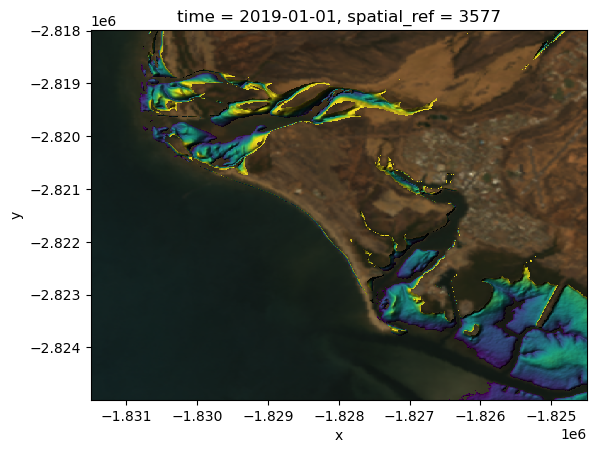

In [246]:
testing = intertidal_ds.isel(x=slice(-750, -50), y=slice(200, 900))
testing.isel(time=0).to_array().plot.imshow()

Exporting animation to animation.gif


  0%|          | 0/5 (0.0 seconds remaining at ? frames/s)

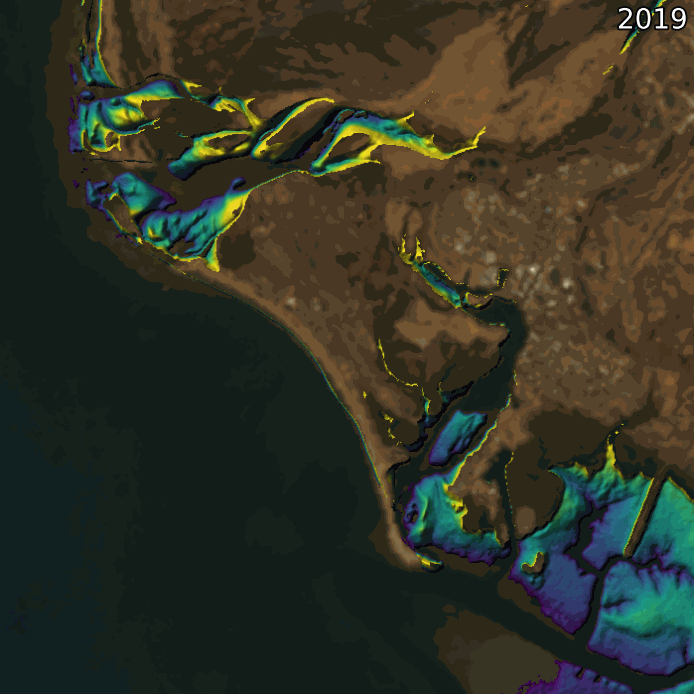

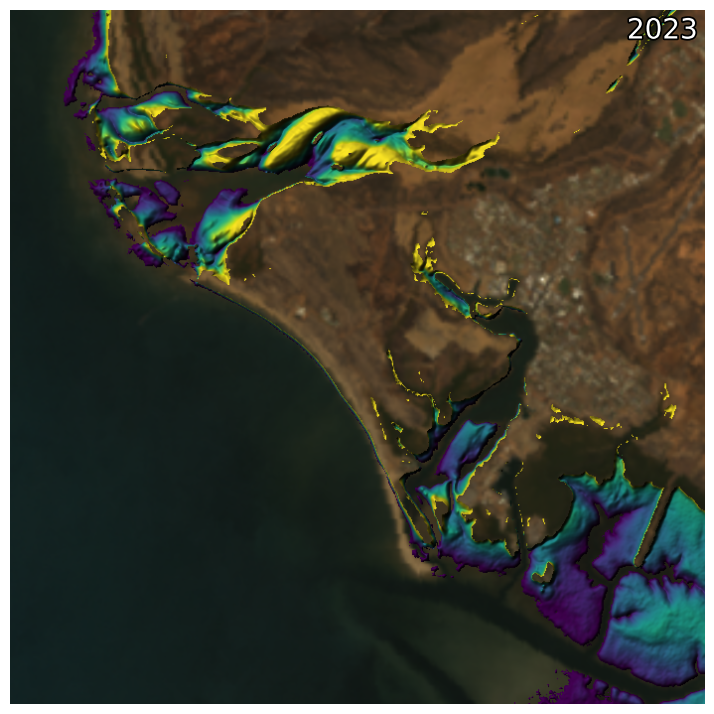

In [247]:
xr_animation(
    ds=testing,
    bands=["red", "green", "blue"],
    imshow_kwargs={"vmin": 0.0, "vmax": 1.0, "interpolation": "bilinear"},
    output_path="animation.gif",
    interval=200,
    show_date='%Y'
)
Image("animation.gif")